## 

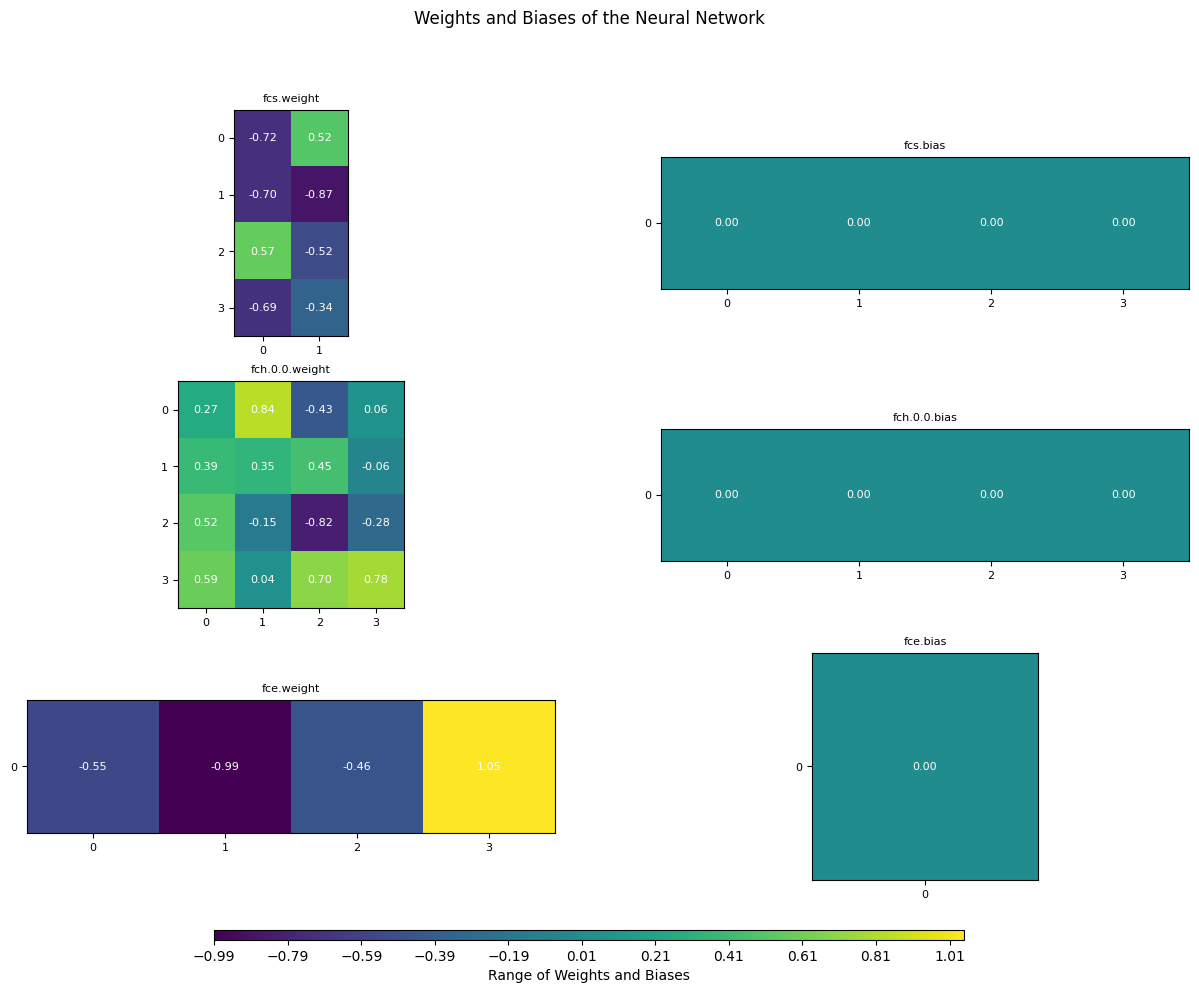

In [74]:
import torch
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, N_OUTPUT = 1, hidden_layers = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        #self.fcs = nn.Sequential(
        #    nn.Linear(N_INPUT, hidden_layers[0]),
        #    self.activation
        #)
        self.fcs = nn.Linear(N_INPUT, hidden_layers[0])

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_layers[i], hidden_layers[i + 1]),
                self.activation
            ) for i in range(len(hidden_layers) - 1)
        ])

        self.fce = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)


    def forward(self, x):
        x = self.activation(fcs(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fce(x)
        return x
    
    def initialize_parameters(self, initialization):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")

    def plot_weights(self):
        weights_biases_dict = self.state_dict()
        #weights_biases_dict = {key: value for key, value in state_dict.items()}
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = 8)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = 8)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = 8)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = 8, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network')
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.set_label('Range of Weights and Biases') 
        
        # Show the plots
        plt.show()

# Step 1: Create the original model
original_input_size = 2
original_hidden_layers = [4, 4]
original_output_size = 1
original_model = FCN(original_input_size, original_output_size, original_hidden_layers, activation='Tanh', initialization='Xavier')
original_model.plot_weights()

